# Resumen

La propuesta inicial es que, a partir de una imagen, el modelo segmente los objetos de la escena y, mediante heurísticas se le asigna peso a cada uno de los objetos e intenta detectar ciertos patrones que penalizan la accesibilidad del espacio, el puntaje de accesibilidad final es la suma de todos los puntajes computados.

# Puntos a agregar en proximos analisis

- Testear el algoritmo en casos extremos de imagenes (imagenes con mucha accesibilidad y otras con poca)
- Generar un dataset para validar como se comporta la métrica
- Cambiar algoritmo heuristico por un clasificador, para que aprenda los patrones automaticamente
- Pensar si la métrica de accesibilidad se deberia perfilar según el usuario (por ahora el enfoque son adultos mayores)

# Limitaciones de lo planteado

 - La métrica puede no ser consistente entre imágenes distintas del mismo lugar.
 - No realiza estimaciones precisas sobre las posiciones o dimensiones de objetos, por lo que se pierde el contexto entre los objetos en el espacio. Esto es debido a que perspectiva de la cámara distorsiona las medidas y no se puede estimar precisamente las caracteristicas usando como entrada sólo una imagen 2D.
 - Los errores del modelo de segmentación afectan la evaluación final

# Instalar dependencias

In [86]:
!pip install matplotlib numpy opencv-python timm datasets scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 111.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 67.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [71]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [72]:
!pip install segmentation-models-pytorch transformers timm albumentations


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Imports

In [2]:
import torch
import torchvision
import requests
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
from scipy.ndimage import center_of_mass
from datasets import load_dataset

ADE20K_LABELS = [
    'pared', 'edificio', 'cielo', 'suelo', 'árbol', 'techo', 'carretera', 'cama', 'ventana',
    'césped', 'armario', 'acera', 'persona', 'tierra', 'puerta', 'mesa', 'montaña', 'planta', 'cortina',
    'silla', 'coche', 'agua', 'pintura', 'sofá', 'estantería', 'casa', 'mar', 'espejo', 'alfombra',
    'campo', 'sillón', 'asiento', 'valla', 'escritorio', 'roca', 'guardarropa', 'lámpara', 'bañera', 'barandilla',
    'cojín', 'base', 'caja', 'columna', 'cartel', 'cómoda', 'mostrador', 'arena', 'fregadero', 'rascacielos',
    'chimenea', 'nevera', 'tribuna', 'camino', 'escaleras', 'pista de aterrizaje', 'vitrina', 'mesa de billar', 'almohada', 'puerta mosquitera',
    'escalera', 'río', 'puente', 'librero', 'persiana', 'mesa de centro', 'inodoro', 'flor', 'libro', 'colina',
    'banco', 'encimera', 'estufa', 'palmera', 'isla de cocina', 'computadora', 'silla giratoria', 'barco', 'bar', 'máquina recreativa',
    'choza', 'autobús', 'toalla', 'luz', 'camión', 'torre', 'candelabro', 'toldo', 'farola', 'puesto',
    'televisor', 'avión', 'pista de tierra', 'ropa', 'poste', 'terreno', 'pasamanos', 'escalera mecánica', 'otomana', 'botella',
    'bufé', 'póster', 'escenario', 'furgoneta', 'barco grande', 'fuente', 'cinta transportadora', 'toldo', 'lavadora', 'juguete',
    'piscina', 'taburete', 'barril', 'cesta', 'cascada', 'tienda de campaña', 'bolsa', 'minimoto', 'cuna', 'horno',
    'pelota', 'comida', 'escalón', 'tanque', 'marca comercial', 'microondas', 'olla', 'animal', 'bicicleta', 'lago',
    'lavavajillas', 'pantalla', 'manta', 'escultura', 'capó', 'aplique', 'jarrón', 'semáforo', 'bandeja', 'cubo de basura',
    'ventilador', 'muelle', 'pantalla CRT', 'plato', 'monitor', 'tablón de anuncios', 'ducha', 'radiador', 'vaso', 'reloj',
    'bandera'
]



# Cargar imagen

In [3]:
#url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEgfWXmFKYvQFDslHyccgcAu6lxT8ni-ENcvKvI9IszGMdN6oqJgnot919N6HwpDPnYPaLGUrPPvglkZI0vHBZHLFPxZML6tsIytTmRmQcT3vqaWSMEwCovSgYeD7eW0tDSsYRRrQBtPaWzk/s1600/4+035.jpg"  
#url = "https://billiken.lat/wp-content/uploads/2023/01/empinada.jpg"
#url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEgt40JZJU8kFWjB2y2Ti3TPeJD0YDKIbHrHBJfMLiUDXqjR6xiS6SlHYgidZgczMLF22GeeTY5srhugk-am8o6DYaT2MEKdrpedCYweWQEZlCheGevLxY2g0dZ1tyB4qB7JTinaponnKfw/s500/pradera.jpg"
url = "https://images.unsplash.com/photo-1507089947368-19c1da9775ae?q=80&w=876&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
input_image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

# Segmentación


Usamos el modelo preentrenado UperNet con ADE20K porque tiene las clases específicas que necesitamos: barandillas, escaleras, pasamanos, escalones, etc para accesibilidad. Los datasets básicos como COCO solo tienen objetos generales.

## import torch
from PIL import Image
import numpy as np
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-small")
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-small").to(device)
model.eval()

def segmentar_imagen(input_image):
    # Convert to PIL if not already
    if not isinstance(input_image, Image.Image):
        input_image = Image.fromarray(np.array(input_image))

    inputs = processor(images=input_image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted segmentation
    logits = outputs.logits  # [batch, num_classes, h, w]
    segmentation = logits.argmax(1).squeeze().cpu().numpy()
    return segmentation


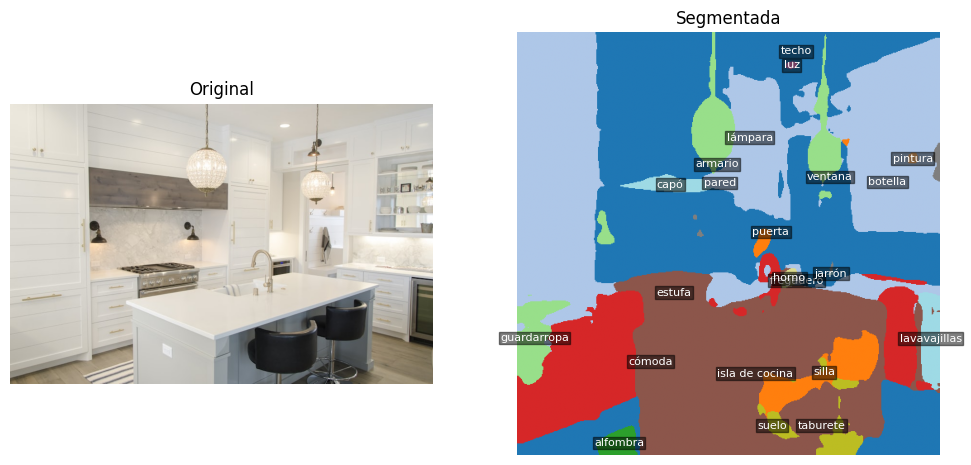

In [5]:
seg_mask = segmentar_imagen(input_image)
plt.figure(figsize=(12,6))

# Original image
plt.subplot(1,2,1)
plt.imshow(input_image)
plt.title("Original")
plt.axis("off")

# Segmentation mask
plt.subplot(1,2,2)
plt.imshow(seg_mask, cmap='tab20')
plt.title("Segmentada")
plt.axis("off")

unique_classes = np.unique(seg_mask)
for cls in unique_classes:
    if cls >= len(ADE20K_LABELS):
        continue

    y, x = center_of_mass(seg_mask == cls)
    if not np.isnan(x) and not np.isnan(y):
        plt.text(x, y, ADE20K_LABELS[cls], color='white', fontsize=8,
                 ha='center', va='center',
                 bbox=dict(facecolor='black', alpha=0.5, pad=1))

plt.show()

# Algoritmo heuristico

Los objetos que pueden ser potencialmente un obstaculo tienen una valoración negativa y los que facilitan la accesibilidad un valor positivo. No lo hacemos con todos los objetos del dataset, sino los que consideramos que a priori afectan a la accesibilidad. También consideramos combinaciones problemáticas específicas (ej: escaleras sin barandilla = riesgo alto).

In [20]:
PESOS_OBJETOS = {
    # Facilitan accesibilidad
    'barandilla': 3, 'pasamanos': 3, 'escalera mecánica': 3,
    'puerta': 2, 'luz': 2, 'lámpara': 2, 'farola': 2,
    'camino': 2, 'acera': 2, 'puente': 2, 'inodoro': 2,
    'ventana': 1, 'banco': 1, 'asiento': 1, 'aplique': 1,

    # Obstáculos
    'escaleras': -4, 'escalón': -3,
    'caja': -2, 'mesa de centro': -2, 'otomana': -2, 'taburete': -2,
    'columna': -2, 'juguete': -2,
    'alfombra': -1, 'bolsa': -1, 'ropa': -1, 'cesta': -1,
}

PATRONES_CRITICOS = {
    "escaleras_sin_baranda": (["escaleras"], ["pasamanos", "barandilla"]),
    "escaleras_sin_luz": (["escaleras"], ["luz", "lámpara", "farola", "aplique"]),
    "baño_sin_apoyo": (["inodoro", "ducha"], ["barandilla", "pasamanos"]),
    "entrada_con_escalon": (["puerta", "escalón"], []),
}

In [21]:
def calcular_puntaje(objetos: list[str]) -> int:
    """Suma los pesos de los objetos detectados."""
    return sum(PESOS_OBJETOS.get(o, 0) for o in objetos)


def detectar_problemas(objetos: list[str]) -> list[str]:
    """Identifica problemas críticos según patrones definidos."""
    encontrados = set(objetos)
    problemas = []
    for patron, (requeridos, soportes) in PATRONES_CRITICOS.items():
        if all(r in encontrados for r in requeridos):
            if not any(s in encontrados for s in soportes):
                problemas.append(patron)
    return problemas


def clasificar_nivel(puntaje: int, problemas: list[str]) -> str:
    """Clasifica accesibilidad según puntaje y problemas críticos."""
    if puntaje >= 8:
        nivel = "excelente"
    elif puntaje >= 4:
        nivel = "bueno"
    elif puntaje >= 0:
        nivel = "aceptable"
    elif puntaje >= -4:
        nivel = "deficiente"
    else:
        nivel = "crítico"

    # Ajustes por problemas críticos
    if problemas and nivel in ("excelente", "bueno"):
        nivel = "aceptable"
    if len(problemas) > 2:
        nivel = "deficiente"

    return nivel


def evaluar_accesibilidad(objetos: list[str]) -> dict:
    """Evalúa accesibilidad de un espacio."""
    puntaje = calcular_puntaje(objetos)
    problemas = detectar_problemas(objetos)
    nivel = clasificar_nivel(puntaje, problemas)

    return {
        "puntaje": puntaje,
        "nivel": nivel,
        "problemas_criticos": problemas,
        "caracteristicas_accesibilidad": [o for o in objetos if PESOS_OBJETOS.get(o, 0) > 0],
        "barreras": [o for o in objetos if PESOS_OBJETOS.get(o, 0) < 0],
    }




In [22]:
objetos = [ADE20K_LABELS[i] for i in np.unique(seg_mask)]
evaluar_accesibilidad(objetos)

{'puntaje': 4,
 'nivel': 'bueno',
 'problemas_criticos': [],
 'caracteristicas_accesibilidad': ['ventana', 'puerta', 'lámpara', 'luz'],
 'barreras': ['alfombra', 'taburete']}

# Estimación de profundidad (no se utiliza)

In [59]:
def generar_mapa_de_profundidad(input_image, target_size=(512, 512)):
    midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
    midas.eval()
    
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform_depth = midas_transforms.dpt_transform
    
    # Convert image to numpy
    img_np = np.array(input_image).astype(np.float32)
    input_batch = transform_depth(img_np)
    
    # Inference
    with torch.no_grad():
        depth_output = midas(input_batch)
        depth = depth_output.squeeze().cpu().numpy()
    
    # Resize to target_size (H, W)
    depth_resized = cv2.resize(depth, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    
    return depth_resized

Using cache found in /home/ubuntu/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/ubuntu/.cache/torch/hub/intel-isl_MiDaS_master


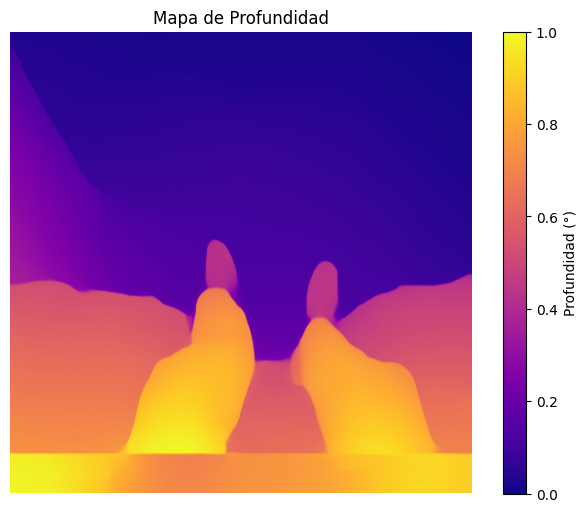

In [60]:
mapa_prof = generar_mapa_de_profundidad(input_image)
prof_min = mapa_prof.min()
prof_max = mapa_prof.max()
prof_normalizado = (mapa_prof - prof_min) / (prof_max - prof_min)

plt.figure(figsize=(8,6))
plt.imshow(prof_normalizado, cmap='plasma')
plt.title("Mapa de Profundidad")
plt.colorbar(label='Profundidad (°)')
plt.axis("off")
plt.show()

In [67]:
cls_piso = ADE20K_LABELS.index('mountain') # grass, floor, field
mascara_piso = seg_mask == cls_piso
#grad_y, grad_x = np.gradient(np.where(mascara_piso, mapa_prof, np.nan))

delta = np.abs(np.gradient(np.where(mascara_piso, mapa_prof, np.nan)))  # magnitud relativa
x1_relative = (delta - np.nanmin(delta)) / (np.nanmax(delta) - np.nanmin(delta))
x1 = np.nanmedian(x1_relative)  # métrica de stepness relativa
x1

np.float32(0.0015301969)

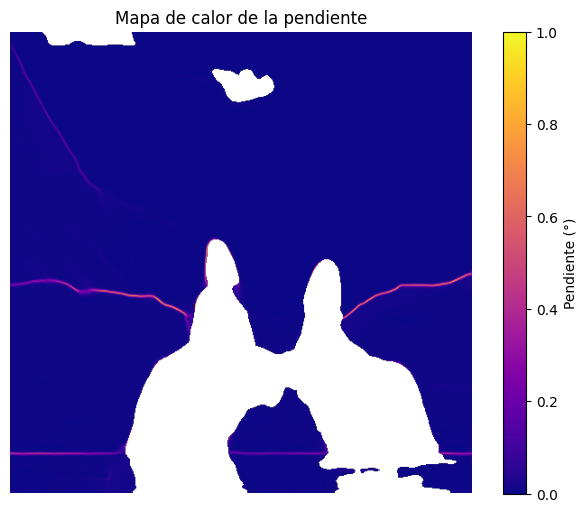

In [64]:
import matplotlib.pyplot as plt
import numpy as np

mask_display = np.where(mascara_piso, g_norm, np.nan)

plt.figure(figsize=(8,6))
plt.imshow(mask_display, cmap='plasma')  # o 'viridis', 'inferno'
plt.colorbar(label='Pendiente (°)')
plt.title("Mapa de calor de la pendiente")
plt.axis('off')
plt.show()
